In [14]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

In [19]:
SPLITS = {
    'train': ('2024-01-16', '2024-06-30'),
    'validate': ('2024-07-01', '2024-08-31'), 
    'test': ('2024-09-01', '2025-01-14')
}

split_name = 'train'
model_name = "transformer"
run_name = "dana"
# Convert dates to datetime for comparison
split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
split_end = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
# Adjust this path to your inference CSV files.
data_pattern = f'/Users/raghuvar/Code/dataBAM/inference/{model_name}/{run_name}*/inference/*.5min.csv'


def load_file(filepath):
    """
    Load a CSV file and extract the date (YYYYMMDD from the filename).
    """
    df = pd.read_csv(filepath)
    # Extract the first 8 characters from the filename as the date string.
    file_date = os.path.basename(filepath)[:8]
    # Convert to datetime
    df['date'] = pd.to_datetime(file_date, format='%Y%m%d', errors='coerce')
    return df

def load_split_data(split_name, data_pattern):
    """
    Load and concatenate all CSV files (matching data_pattern) that fall into the
    given split period.
    
    Parameters:
      split_name: 'train', 'validate', or 'test'
      data_pattern: glob pattern (e.g., '/path/to/inference/*.5min.csv')
    
    Returns:
      A concatenated DataFrame.
    """
    split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
    split_end   = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
    
    all_files = glob.glob(data_pattern)
    files_in_split = []
    dfs = []
    for f in all_files:
        try:
            file_date = datetime.strptime(os.path.basename(f)[:8], '%Y%m%d')
        except Exception as e:
            print(f"Error parsing date from {f}: {e}")
            continue
        if split_start <= file_date <= split_end:
            files_in_split.append(f)
            dfs.append(load_file(f))
            
    print(f"Found {len(files_in_split)} files in '{split_name}' period")
    if files_in_split:
        print(f"First file: {files_in_split[0]}")
        print(f"Last file:  {files_in_split[-1]}")
        
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def add_time_features(df):
    """
    Add time-based features from the 'minute' column (assumed format "HH:MM").
    
    Adds:
      - 'hour': integer hour (from the first two characters)
      - 'minute_in_hour': integer minutes (from the characters after ':')
      - 'minutes_from_open': minutes since market open (assumed 9:30)
    """
    df = df.copy()
    # Assume 'minute' is a string "HH:MM"
    df['hour'] = df['minute'].str[:2].astype(int)
    df['minute_in_hour'] = df['minute'].str[3:].astype(int)
    # Calculate minutes from market open (9:30)
    df['minutes_from_open'] = ((df['hour'] - 9) * 60 + df['minute_in_hour'] - 30)
    return df

# =============================================================================
# Missing Data Analysis
# =============================================================================
def analyze_missing_predictions(df):
    """
    Analyze missing predicted values.
    Reports the overall missing percentage, and plots the count of missing
    predictions by hour. Also prints the top 10 symbols with missing predictions.
    """
    missing_mask = df['predicted.volatility'].isna()
    n_missing = missing_mask.sum()
    total = len(df)
    print(f"Overall missing predicted.volatility: {n_missing} out of {total} rows ({100 * n_missing/total:.2f}%)")
    
    # Use the 'hour' column (or recompute it if needed)
    if 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
    missing_by_hour = df[missing_mask].groupby('hour').size()
    
    # Plot a simple bar chart for missing predictions by hour.
    plt.figure(figsize=(8, 4))
    plt.bar(missing_by_hour.index.astype(str), missing_by_hour.values, color='skyblue')
    plt.title("Missing Predictions by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count of Missing Predictions")
    plt.tight_layout()
    plt.show()
    
    # Distribution by symbol
    missing_by_symbol = df[missing_mask].groupby('symbol').size()
    print("\nTop 10 symbols with missing predictions:")
    print(missing_by_symbol.nlargest(10))
    return missing_by_hour, missing_by_symbol


def analyze_late_missing(df, symbol='TDG', min_minute='10:00'):
    """
    Analyze missing predictions for a specific symbol after a given time.
    
    Parameters:
    -----------
    df : DataFrame with columns 'symbol', 'minute', 'predicted.volatility'
    symbol : str, symbol to analyze
    min_minute : str, only look at missing values after this time (HH:MM)
    """
    # Create missing mask
    missing_mask = df['predicted.volatility'].isna()
    
    # Filter for specific symbol and missing values
    symbol_missing = df[
        (df['symbol'] == symbol) & 
        missing_mask & 
        (df['minute'] > min_minute)
    ]
    
    # Sort by minute descending to see latest missing values first
    late_missing = symbol_missing.sort_values('minute', ascending=False)[
        ['date', 'minute', 'Y_log_vol_10min_lag_1m']
    ]
    
    print(f"\nMissing predictions for {symbol} after {min_minute}:")
    print(late_missing.head(20))  # Show top 20 latest missing values
    
    return late_missing


# =============================================================================
# Metrics and Error Analysis
# =============================================================================
def compute_overall_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute overall metrics: RMSE, MAE, Pearson correlation, and Spearman correlation.
    
    Uses only NumPy for correlation calculations.
    """
    valid = df[[target_col, pred_col]].dropna()
    error = valid[pred_col] - valid[target_col]
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(error))
    
    # Pearson correlation using np.corrcoef
    pearson_corr = np.corrcoef(valid[pred_col].values, valid[target_col].values)[0,1]
    # Spearman correlation: compute ranks and then use np.corrcoef
    rank_pred = valid[pred_col].rank().values
    rank_target = valid[target_col].rank().values
    spearman_corr = safe_corrcoef(rank_pred, rank_target)
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr
    }
    print("Overall Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    return metrics

def analyze_predictions(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze predictions versus targets.
    Computes overall RMSE and rank correlations (grouped by date and hour),
    produces a scatter plot and an error histogram, and performs a calibration analysis
    by predicted confidence.
    """
    metrics = compute_overall_metrics(df, target_col, pred_col)
    
    # Compute absolute error and add as a new column.
    df = df.copy()
    df['vol_error'] = np.abs(df[pred_col] - df[target_col])
    
    # Scatter plot: Actual vs. Predicted
    valid = df.dropna(subset=[target_col, pred_col])
    plt.figure(figsize=(8,6))
    plt.scatter(valid[target_col], valid[pred_col], alpha=0.3, color='darkorange')
    plt.plot([valid[target_col].min(), valid[target_col].max()],
             [valid[target_col].min(), valid[target_col].max()], 'r--')
    plt.title("Predicted vs. Actual Volatility")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()
    
    # Histogram of absolute error
    plt.figure(figsize=(8,4))
    plt.hist(df['vol_error'].dropna(), bins=50, color='lightgreen', edgecolor='black')
    plt.title("Distribution of Absolute Error")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Compute metrics by hour of day using NumPy correlations
    hourly_metrics = []
    for hour, group in df.groupby('hour'):
        group_valid = group.dropna(subset=[target_col, pred_col])
        if len(group_valid) == 0:
            continue
        err = group_valid[pred_col] - group_valid[target_col]
        rmse_hour = np.sqrt(np.mean(err**2))
        # Compute Spearman correlation manually:
        rank_pred = group_valid[pred_col].rank().values
        rank_target = group_valid[target_col].rank().values
        if len(rank_pred) > 1:
            corr = np.corrcoef(rank_pred, rank_target)[0,1]
        else:
            corr = np.nan
        hourly_metrics.append((hour, rmse_hour, corr))
    hourly_metrics = np.array(hourly_metrics, dtype=object)
    if hourly_metrics.size:
        hours = [int(x) for x in hourly_metrics[:,0]]
        rmse_vals = [float(x) for x in hourly_metrics[:,1]]
        corr_vals = [float(x) for x in hourly_metrics[:,2]]
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
        ax1.bar([str(h) for h in hours], rmse_vals, color='steelblue')
        ax1.set_title("RMSE by Hour")
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("RMSE")
    
        ax2.bar([str(h) for h in hours], corr_vals, color='salmon')
        ax2.set_title("Spearman Corr by Hour")
        ax2.set_xlabel("Hour")
        ax2.set_ylabel("Spearman Correlation")
        plt.tight_layout()
        plt.show()
    
        metrics['time_of_day'] = {'hours': hours, 'rmse': rmse_vals, 'spearman_corr': corr_vals}
    
    # Confidence calibration: group by quantile of predicted confidence
    if 'predicted.vol_confidence' in df.columns:
        # Drop NAs from predicted confidence before binning.
        conf = df['predicted.vol_confidence'].dropna()
        # Create 10 quantile bins
        quantile_bins = pd.qcut(conf, 10, duplicates='drop')
        calib = df.dropna(subset=['predicted.vol_confidence']).groupby(quantile_bins)['vol_error'].mean()
        # Plot calibration: x-axis is bin labels, y-axis is average error.
        plt.figure(figsize=(10,4))
        plt.bar([str(b) for b in calib.index], calib.values, color='mediumpurple', edgecolor='black')
        plt.xticks(rotation=45, ha='right')
        plt.title("Average Absolute Error by Predicted Confidence Quantile")
        plt.xlabel("Predicted Confidence Quantile")
        plt.ylabel("Average Absolute Error")
        plt.tight_layout()
        plt.show()
        metrics['confidence_calibration'] = calib.to_dict()
    else:
        print("Column 'predicted.vol_confidence' not found; skipping confidence calibration analysis.")
    
    return metrics

# =============================================================================
# Regime, Intraday, and Cross‐Sectional Analysis
# =============================================================================
def analyze_regimes(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Divide data into 5 volatility regimes based on target quantiles,
    and compute RMSE, Spearman correlation (using np.corrcoef on ranks),
    and average predicted confidence for each regime.
    """
    df = df.copy()
    df['vol_regime'] = pd.qcut(df[target_col], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    def regime_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return {'rmse': np.nan, 'spearman_corr': np.nan, 'avg_confidence': np.nan, 'n_obs': len(valid)}
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        avg_conf = valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan
        return {'rmse': rmse_val, 'spearman_corr': spearman_corr, 'avg_confidence': avg_conf, 'n_obs': len(valid)}
    
    regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))
    print("\nRegime Metrics:")
    print(regime_metrics_df)
    # Use pandas built-in plot (which calls matplotlib) for a quick view.
    regime_metrics_df[['rmse', 'spearman_corr']].plot(kind='bar', subplots=True, layout=(1,2), figsize=(14,4), legend=False)
    plt.suptitle("Metrics by Volatility Regime")
    plt.tight_layout()
    plt.show()
    
    return regime_metrics_df


def safe_corrcoef(x, y):
    # Compute standard deviations
    std_x = np.std(x)
    std_y = np.std(y)
    if std_x == 0 or std_y == 0:
        return np.nan
    return np.corrcoef(x, y)[0, 1]


def analyze_intraday_pattern(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze intraday performance by grouping by minute-of-day.
    """
    df = df.copy()
    if 'minute_in_hour' not in df.columns or 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
        df['minute_in_hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.minute
    df['minute_of_day'] = df['hour'] * 60 + df['minute_in_hour']
    
    intraday = df.groupby('minute_of_day').apply(lambda x: pd.Series({
        'rmse': np.sqrt(np.mean((x[pred_col] - x[target_col])**2)),
        'spearman_corr': np.corrcoef(x[pred_col].rank().values, x[target_col].rank().values)[0,1] if len(x) > 1 else np.nan,
        'avg_confidence': x['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in x.columns else np.nan,
        'n_obs': len(x)
    })).reset_index()
    
    plt.figure(figsize=(12,4))
    plt.plot(intraday['minute_of_day'], intraday['rmse'], marker='o', linestyle='-')
    plt.title("Intraday RMSE Pattern")
    plt.xlabel("Minute of Day")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()
    
    return intraday

def compute_symbol_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute per-symbol metrics (RMSE, Pearson and Spearman correlations, etc.)
    using NumPy for correlation computations.
    """
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({
                'rmse': np.nan,
                'pearson_corr': np.nan,
                'spearman_corr': np.nan,
                'avg_confidence': np.nan,
                'avg_vol': np.nan,
                'n_observations': len(valid)
            })
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        pearson = np.corrcoef(valid[pred_col].values, valid[target_col].values)[0,1]
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman = np.corrcoef(rank_pred, rank_target)[0,1]
        avg_conf = valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan
        avg_vol = valid[target_col].mean()
        return pd.Series({
            'rmse': rmse_val,
            'pearson_corr': pearson,
            'spearman_corr': spearman,
            'avg_confidence': avg_conf,
            'avg_vol': avg_vol,
            'n_observations': len(valid)
        })
    cols = ['Y_log_vol_10min_lag_1m', 'predicted.volatility', 'predicted.vol_confidence']
    symbol_metrics = df.groupby('symbol')[cols].apply(compute_metrics)
    return symbol_metrics

# =============================================================================
# Data Quality Checks
# =============================================================================
def check_data_quality(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Print basic data quality statistics and produce a sample time series plot.
    """
    print("Basic Data Checks:")
    print(f"  Total rows: {len(df)}")
    print("  Missing values:")
    print(df[[pred_col, target_col]].isna().sum())
    print("\n  Descriptive Statistics:")
    print(df[[pred_col, target_col]].describe())
    
    # Show a sample of data for the first symbol
    sample_symbol = df['symbol'].iloc[0]
    sample_data = df[df['symbol'] == sample_symbol].head(10)
    print(f"\nSample data for symbol {sample_symbol}:")
    print(sample_data[['minute', pred_col, target_col, 'predicted.vol_confidence']])
    
    # Plot time series for the sample symbol.
    if not sample_data.empty:
        plt.figure(figsize=(10,4))
        plt.plot(sample_data['minute'], sample_data[target_col], label="Actual", marker='o')
        plt.plot(sample_data['minute'], sample_data[pred_col], label="Predicted", linestyle='--', marker='x')
        plt.title(f"Time Series for {sample_symbol}")
        plt.xlabel("Time")
        plt.ylabel("Volatility")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# =============================================================================
# Symbol-Level Performance Analysis
# =============================================================================
def analyze_symbol_performance(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze per-symbol performance after filtering out early market minutes.
    Also apply a simple scaling adjustment so that the prediction mean matches the target mean.
    """
    df = df.copy()
    # Convert 'minute' to datetime if not already done
    df['minute'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce')
    df['hour'] = df['minute'].dt.hour
    df['minute_int'] = df['minute'].dt.minute
    df['minutes_from_open'] = (df['hour'] - 9) * 60 + df['minute_int'] - 30
    
    # Filter out data before 30 minutes after market open
    df_clean = df[df['minutes_from_open'] >= 30].copy()
    
    # Scale predictions: adjust so that the mean prediction equals the mean target
    mean_target = df_clean[target_col].mean()
    mean_pred = df_clean[pred_col].mean()
    if mean_pred != 0:
        df_clean['scaled_pred'] = df_clean[pred_col] * mean_target / mean_pred
    else:
        df_clean['scaled_pred'] = df_clean[pred_col]
    
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({
                'rmse_original': np.nan,
                'rmse_scaled': np.nan,
                'spearman_corr': np.nan,
                'avg_confidence': np.nan,
                'avg_target': np.nan,
                'n_observations': len(valid),
                'n_unique_preds': valid[pred_col].nunique()
            })
        err_orig = valid[pred_col] - valid[target_col]
        err_scaled = valid['scaled_pred'] - valid[target_col]
        rmse_orig = np.sqrt(np.mean(err_orig**2))
        rmse_scaled = np.sqrt(np.mean(err_scaled**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        return pd.Series({
            'rmse_original': rmse_orig,
            'rmse_scaled': rmse_scaled,
            'spearman_corr': spearman_corr,
            'avg_confidence': valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan,
            'avg_target': valid[target_col].mean(),
            'n_observations': len(valid),
            'n_unique_preds': valid[pred_col].nunique()
        })
    
    symbol_perf = df_clean.groupby('symbol').apply(compute_metrics)
    
    print("\nOverall Symbol-Level Performance Summary:")
    print(symbol_perf.describe())
    
    # Plot the distribution of original RMSE across symbols.
    plt.figure(figsize=(8,4))
    plt.hist(symbol_perf['rmse_original'].dropna(), bins=50, color='lightblue', edgecolor='black')
    plt.title("Distribution of Original Symbol-level RMSE")
    plt.xlabel("RMSE")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Print top 10 symbols by Spearman correlation.
    valid_corrs = symbol_perf[symbol_perf['spearman_corr'].notna()]
    if len(valid_corrs) > 0:
        top_symbols = valid_corrs.sort_values('spearman_corr', ascending=False).head(10)
        print("\nTop 10 symbols by Spearman correlation:")
        print(top_symbols[['spearman_corr', 'n_observations', 'n_unique_preds']])
    else:
        print("No valid correlations found.")
    
    return symbol_perf


In [20]:

print(data_pattern)
# Load data for the chosen split.
df = load_split_data(split_name, data_pattern)
if df.empty:
    raise ValueError("No data loaded. Check your file paths and date ranges.")

# Add time features.
df = add_time_features(df)

/Users/raghuvar/Code/dataBAM/inference/transformer/dana*/inference/*.5min.csv
Found 115 files in 'train' period
First file: /Users/raghuvar/Code/dataBAM/inference/transformer/dana_transformer_20250204_0855/inference/20240626.5min.csv
Last file:  /Users/raghuvar/Code/dataBAM/inference/transformer/dana_transformer_20250204_0855/inference/20240425.5min.csv


In [15]:

analyze_late_missing(df)


Missing predictions for TDG after 10:00:
              date minute  Y_log_vol_10min_lag_1m
1890307 2024-03-18  10:35                0.000224
3121877 2024-02-16  10:30                0.000517
4551375 2024-05-20  10:30                0.000425
2506566 2024-03-14  10:30                0.000161
5031179 2024-02-26  10:30                0.000171
7564839 2024-02-20  10:25                0.000431
1890306 2024-03-18  10:25                0.000469
7151237 2024-03-22  10:25                0.000670
4757899 2024-04-29  10:25                0.000467
2506565 2024-03-14  10:25                0.000374
4079436 2024-01-26  10:25                0.000400
3052599 2024-01-31  10:25                0.000276
327440  2024-04-08  10:25                0.000201
261009  2024-04-09  10:20                0.000680
4690191 2024-02-12  10:20                0.000114
6672433 2024-02-02  10:20                0.000652
1010913 2024-05-16  10:20                0.000690
2983090 2024-01-30  10:20                0.000214
5305163 

,date,minute,Y_log_vol_10min_lag_1m
1890307,2024-03-18,10:35,0.000224
3121877,2024-02-16,10:30,0.000517
4551375,2024-05-20,10:30,0.000425
2506566,2024-03-14,10:30,0.000161
5031179,2024-02-26,10:30,0.000171
...,...,...,...
3188991,2024-05-24,10:05,0.000895
3121876,2024-02-16,10:05,0.000369
3052596,2024-01-31,10:05,0.000380
2983088,2024-01-30,10:05,0.000406


Basic Data Checks:
  Total rows: 7851907
  Missing values:
predicted.volatility      692450
Y_log_vol_10min_lag_1m         0
dtype: int64

  Descriptive Statistics:
       predicted.volatility  Y_log_vol_10min_lag_1m
count          7.159457e+06            7.851907e+06
mean           5.717859e-03            6.988477e-04
std            7.408690e-01            1.327302e-03
min           -1.071289e+00            0.000000e+00
25%           -3.942871e-01            3.132678e-04
50%           -1.927490e-01            4.957088e-04
75%            1.490479e-01            8.060710e-04
max            8.320312e+00            1.334344e+00

Sample data for symbol A:
  minute  predicted.volatility  Y_log_vol_10min_lag_1m  \
0  09:40                   NaN                0.001617   
1  09:45                   NaN                0.000997   
2  09:50                   NaN                0.000965   
3  09:55                   NaN                0.000802   
4  10:00                   NaN                0.00

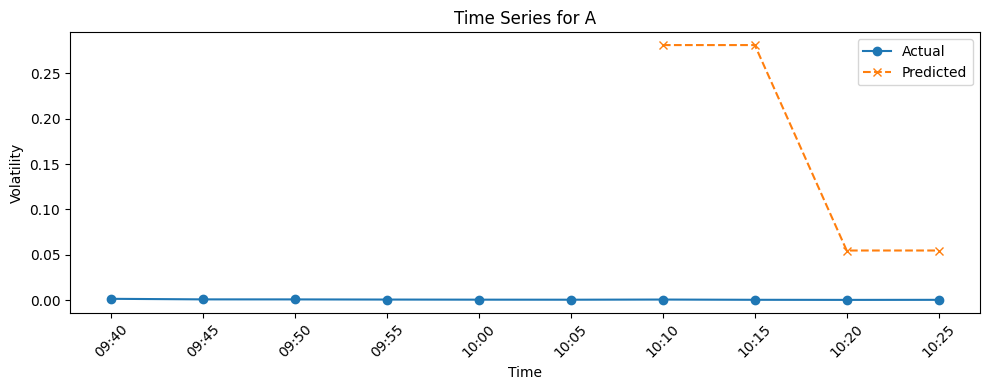

Overall missing predicted.volatility: 692450 out of 7851907 rows (8.82%)


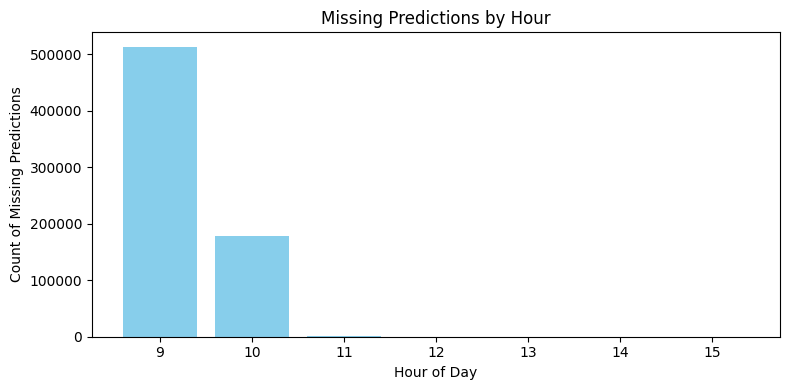


Top 10 symbols with missing predictions:
symbol
TDG     730
WWD     728
POOL    727
NXST    724
TXRH    724
MKTX    723
URI     722
BECN    721
JKHY    721
NTRA    719
dtype: int64
Overall Metrics:
  rmse: 0.7404
  mae: 0.4520
  pearson_corr: 0.5476
  spearman_corr: 0.7878


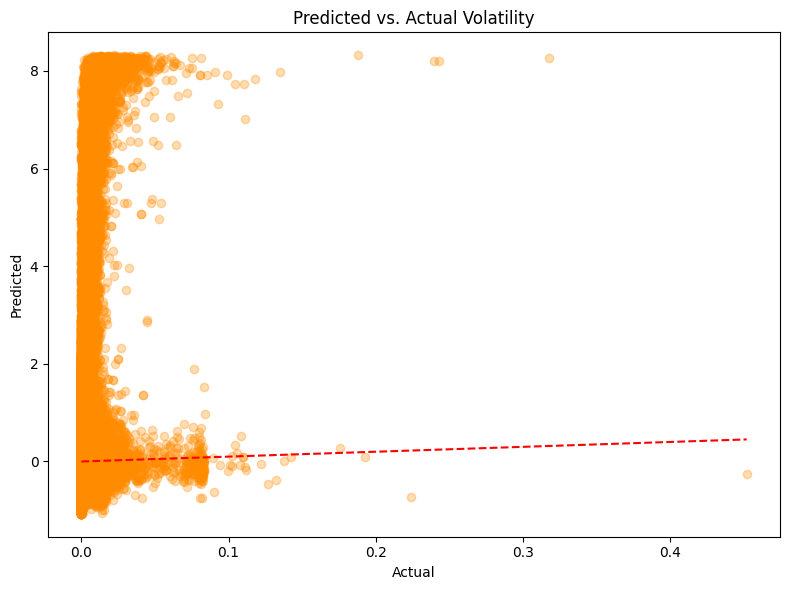

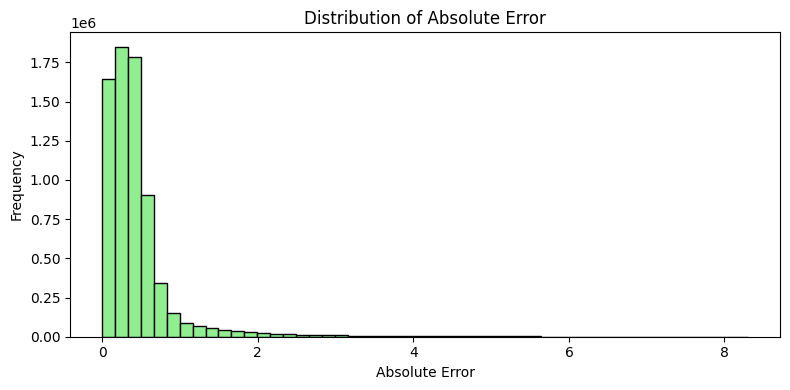

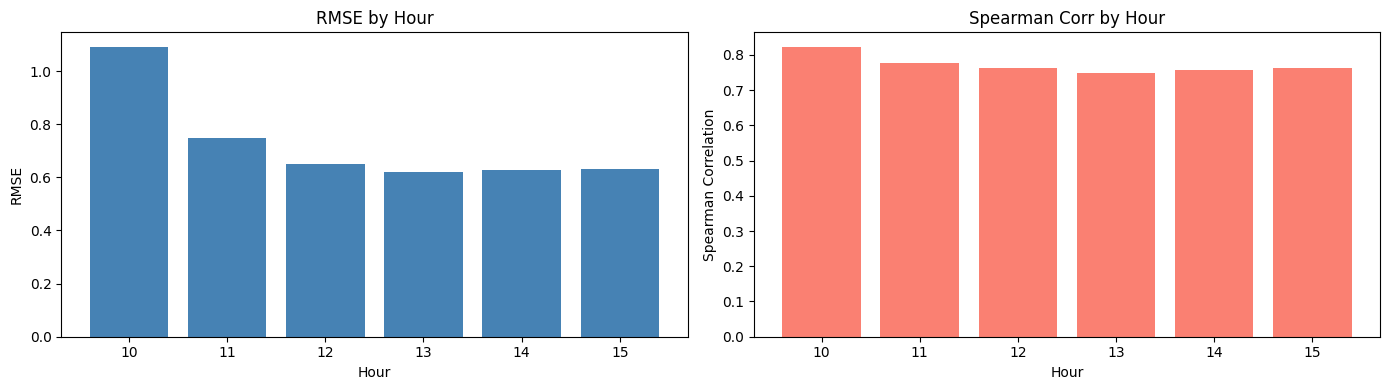

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1841144102.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.dropna(subset=['predicted.vol_confidence']).groupby(quantile_bins)['vol_error'].mean()


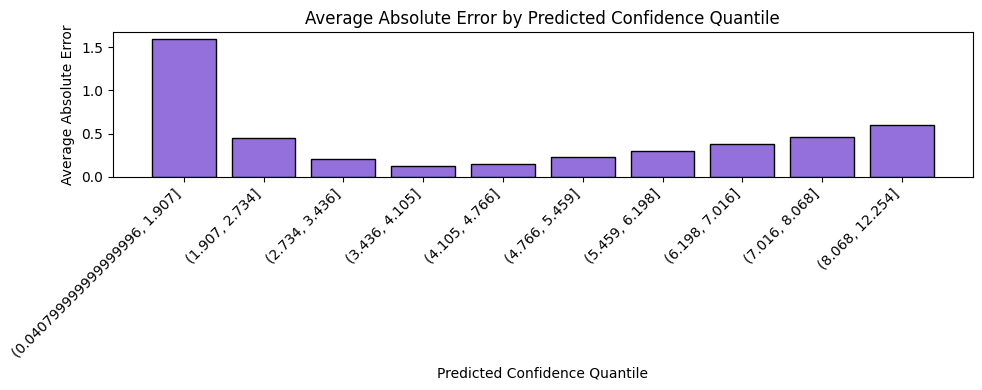

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1841144102.py:296: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))



Regime Metrics:
                rmse  spearman_corr  avg_confidence      n_obs
vol_regime                                                    
Very Low    0.513123       0.402332        7.087326  1531838.0
Low         0.358244       0.223544        5.904920  1530778.0
Medium      0.294581       0.221259        4.859030  1494715.0
High        0.389636       0.284126        3.721189  1407087.0
Very High   1.579436       0.557928        2.172098  1195039.0


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1841144102.py:296: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))


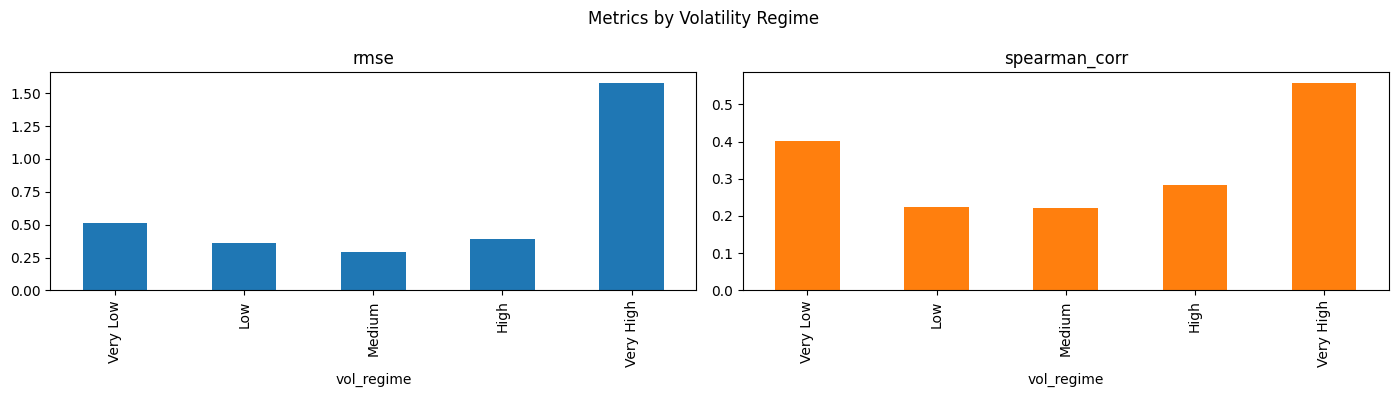

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1841144102.py:327: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  intraday = df.groupby('minute_of_day').apply(lambda x: pd.Series({


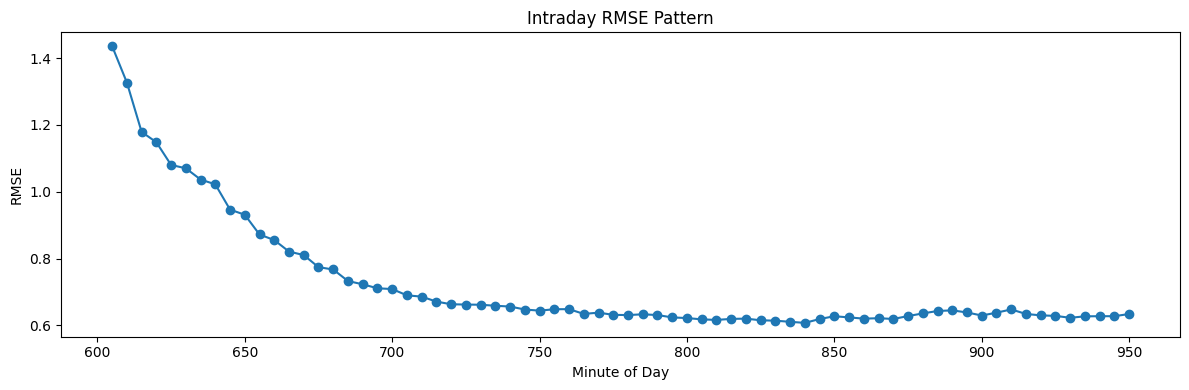

/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/raghuvar/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Overall Symbol-Level Performance Summary:
       rmse_original  rmse_scaled  spearman_corr  avg_confidence   avg_target  \
count    1555.000000  1555.000000    1554.000000     1555.000000  1555.000000   
mean        0.723244     0.082002       0.539808        4.318285     0.000811   
std         0.909871     0.102660       0.123536        2.175150     0.000942   
min         0.186641     0.021458      -0.303363        0.053895     0.000000   
25%         0.348726     0.039794       0.481496        2.685999     0.000447   
50%         0.432127     0.049273       0.562394        4.148142     0.000598   
75%         0.651596     0.073959       0.619489        5.856588     0.000844   
max         7.615561     0.860002       0.879538        9.815772     0.011997   

       n_observations  n_unique_preds  
count     1555.000000     1555.000000  
mean      4604.152412     1510.176849  
std       3011.645899      989.290307  
min         12.000000        7.000000  
25%       1279.000000      

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1841144102.py:468: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  symbol_perf = df_clean.groupby('symbol').apply(compute_metrics)


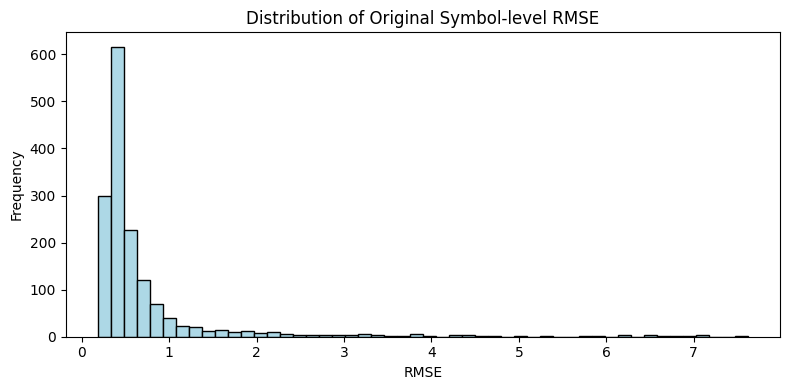


Top 10 symbols by Spearman correlation:
        spearman_corr  n_observations  n_unique_preds
symbol                                               
HCP          0.879538          6441.0          2293.0
SWAV         0.863912          5405.0          2002.0
AY           0.840582          1033.0           492.0
ALPN         0.839304          2596.0           880.0
TSLZ         0.799999           571.0           270.0
WIRE         0.795804          4467.0          1667.0
AMC          0.782333          1855.0           799.0
GL           0.780642          4313.0          1936.0
SLV          0.777236          6815.0          2426.0
SOUN         0.773018          5278.0          1896.0

Overall Metrics:
{'rmse': 0.7403546615594284, 'mae': 0.4519803838844661, 'pearson_corr': 0.5476284902902308, 'spearman_corr': 0.7877796506046549, 'time_of_day': {'hours': [10, 11, 12, 13, 14, 15], 'rmse': [1.0910246202845943, 0.7487711290124468, 0.6499071733709804, 0.6214672860859671, 0.627752439347638, 0.631

In [21]:


# Perform basic data quality checks.
check_data_quality(df)

# Analyze missing predictions.
analyze_missing_predictions(df)

# Compute and display overall prediction metrics and generate plots.
overall_metrics = analyze_predictions(df)

# Analyze performance across volatility regimes.
regime_metrics = analyze_regimes(df)

# Analyze intraday error patterns.
intraday_metrics = analyze_intraday_pattern(df)

# Compute cross-sectional (symbol-level) metrics.
symbol_metrics = compute_symbol_metrics(df)

# Analyze symbol-level performance with scaling adjustment.
symbol_perf = analyze_symbol_performance(df)

# Optionally, save the summaries to CSV files.
symbol_metrics.to_csv("symbol_metrics_summary.csv", index=True)
symbol_perf.to_csv("symbol_performance.csv", index=True)

# Print final summaries.
print("\nOverall Metrics:")
print(overall_metrics)
print("\nRegime Metrics:")
print(regime_metrics)
print("\nIntraday Metrics (first 10 rows):")
print(intraday_metrics.head(10))
print("\nTop 10 Symbols by Spearman Correlation:")
print(symbol_perf.sort_values('spearman_corr', ascending=False).head(10)[['spearman_corr', 'n_observations', 'n_unique_preds']])

In [23]:
def analyze_confidence_vol_relationship_fixed(df, conf_col='predicted.vol_confidence', 
                                           vol_col='Y_log_vol_10min_lag_1m',
                                           pred_col='predicted.volatility'):
    """
    Analyze relationship between prediction confidence and realized volatility,
    with proper handling of zero volatility cases.
    """
    # Remove NaN values
    valid_data = df.dropna(subset=[conf_col, vol_col, pred_col]).copy()
    
    # 1. Create confidence quintiles
    conf_quintiles = pd.qcut(valid_data[conf_col], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    valid_data['conf_quintile'] = conf_quintiles
    
    # 2. Compute absolute error
    valid_data['abs_error'] = np.abs(valid_data[pred_col] - valid_data[vol_col])
    
    # 3. Modified error metrics that don't require division by target
    quintile_stats = valid_data.groupby('conf_quintile').agg({
        vol_col: ['mean', 'std', 'count', lambda x: np.sum(x == 0)],
        'abs_error': ['mean', 'std', 'median'],
        pred_col: ['mean', 'std']
    }).round(6)
    
    # Rename the zero count column
    quintile_stats[vol_col] = quintile_stats[vol_col].rename(
        columns={'<lambda_0>': 'zero_vol_count'})
    
    print("\n1. Basic Statistics by Confidence Quintile:")
    print(quintile_stats)
    
    # 4. Accuracy bands analysis
    def compute_accuracy_bands(group):
        total = len(group)
        bands = {
            'within_10pct': np.sum(group['abs_error'] <= 0.0001) / total,  # Within 0.01%
            'within_25pct': np.sum(group['abs_error'] <= 0.00025) / total, # Within 0.025%
            'within_50pct': np.sum(group['abs_error'] <= 0.0005) / total,  # Within 0.05%
            'above_100pct': np.sum(group['abs_error'] > 0.001) / total,    # Above 0.1%
            'count': total
        }
        return pd.Series(bands)
    
    accuracy_bands = valid_data.groupby('conf_quintile').apply(compute_accuracy_bands)
    
    print("\n2. Accuracy Bands by Confidence Level:")
    print(accuracy_bands.round(4))
    
    # 5. Confidence vs Volatility Level
    vol_quintiles = pd.qcut(valid_data[vol_col], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    valid_data['vol_quintile'] = vol_quintiles
    
    conf_by_vol = valid_data.groupby('vol_quintile')[conf_col].agg(['mean', 'std', 'count']).round(4)
    
    print("\n3. Confidence by Volatility Level:")
    print(conf_by_vol)
    
    # 6. Day pattern analysis
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour
    
    # Compute various metrics by hour
    hourly_metrics = valid_data.groupby('hour').agg({
        conf_col: ['mean', 'std'],
        'abs_error': ['mean', 'std'],
        vol_col: ['mean', 'std']
    }).round(6)
    
    print("\n4. Hourly Pattern Analysis:")
    print(hourly_metrics)
    
    # 7. Plot key relationships
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Error Distribution by Confidence
    plt.subplot(1, 3, 1)
    error_by_conf = valid_data.groupby('conf_quintile')['abs_error'].mean()
    plt.plot(range(5), error_by_conf.values, 'bo-')
    plt.title('Mean Error by Confidence')
    plt.xticks(range(5), error_by_conf.index, rotation=45)
    
    # Plot 2: Confidence vs Actual Volatility Level
    plt.subplot(1, 3, 2)
    conf_by_vol_mean = valid_data.groupby('vol_quintile')[conf_col].mean()
    plt.plot(range(5), conf_by_vol_mean.values, 'ro-')
    plt.title('Average Confidence by Vol Level')
    plt.xticks(range(5), conf_by_vol_mean.index, rotation=45)
    
    # Plot 3: Hour of Day Pattern
    plt.subplot(1, 3, 3)
    hourly_conf = valid_data.groupby('hour')[conf_col].mean()
    plt.plot(hourly_conf.index, hourly_conf.values, 'go-')
    plt.title('Confidence by Hour')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'quintile_stats': quintile_stats,
        'accuracy_bands': accuracy_bands,
        'conf_by_vol': conf_by_vol,
        'hourly_metrics': hourly_metrics
    }

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/2783771410.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_stats = valid_data.groupby('conf_quintile').agg({



1. Basic Statistics by Confidence Quintile:
              Y_log_vol_10min_lag_1m                               abs_error  \
                                mean       std    count <lambda_0>      mean   
conf_quintile                                                                  
Very Low                    0.001303  0.001382  1432954        NaN  1.022467   
Low                         0.000688  0.000887  1434036        NaN  0.170016   
Medium                      0.000534  0.000854  1432270        NaN  0.187608   
High                        0.000414  0.000718  1431565        NaN  0.344926   
Very High                   0.000265  0.000364  1428632        NaN  0.535119   

                                  predicted.volatility            
                    std    median                 mean       std  
conf_quintile                                                     
Very Low       1.081788  0.702335             1.011368  1.094240  
Low            0.130669  0.142236             

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/2783771410.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_bands = valid_data.groupby('conf_quintile').apply(compute_accuracy_bands)
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/2783771410.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_bands = valid_data.groupby('conf_quintile').apply(compute_accuracy_bands)



2. Accuracy Bands by Confidence Level:
               within_10pct  within_25pct  within_50pct  above_100pct  \
conf_quintile                                                           
Very Low             0.0001        0.0001        0.0003        0.9995   
Low                  0.0004        0.0009        0.0018        0.9962   
Medium               0.0002        0.0006        0.0012        0.9977   
High                 0.0000        0.0000        0.0000        1.0000   
Very High            0.0000        0.0000        0.0000        1.0000   

                   count  
conf_quintile             
Very Low       1432954.0  
Low            1434036.0  
Medium         1432270.0  
High           1431565.0  
Very High      1428632.0  


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/2783771410.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conf_by_vol = valid_data.groupby('vol_quintile')[conf_col].agg(['mean', 'std', 'count']).round(4)



3. Confidence by Volatility Level:
                mean     std    count
vol_quintile                         
Very Low      7.1312  1.9910  1431892
Low           6.0073  1.6541  1431891
Medium        5.0216  1.5426  1431891
High          3.9380  1.3811  1431891
Very High     2.3383  1.2804  1431892

4. Hourly Pattern Analysis:
     predicted.vol_confidence           abs_error            \
                         mean       std      mean       std   
hour                                                          
10                   3.890194  2.237525  0.629511  0.891096   
11                   4.710585  2.255095  0.437457  0.607692   
12                   5.191525  2.291922  0.417528  0.498046   
13                   5.068477  2.105807  0.414434  0.463105   
14                   5.240439  2.329398  0.421808  0.464921   
15                   5.124867  2.265145  0.408982  0.481416   

     Y_log_vol_10min_lag_1m            
                       mean       std  
hour                 

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/2783771410.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_conf = valid_data.groupby('conf_quintile')['abs_error'].mean()
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/2783771410.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conf_by_vol_mean = valid_data.groupby('vol_quintile')[conf_col].mean()


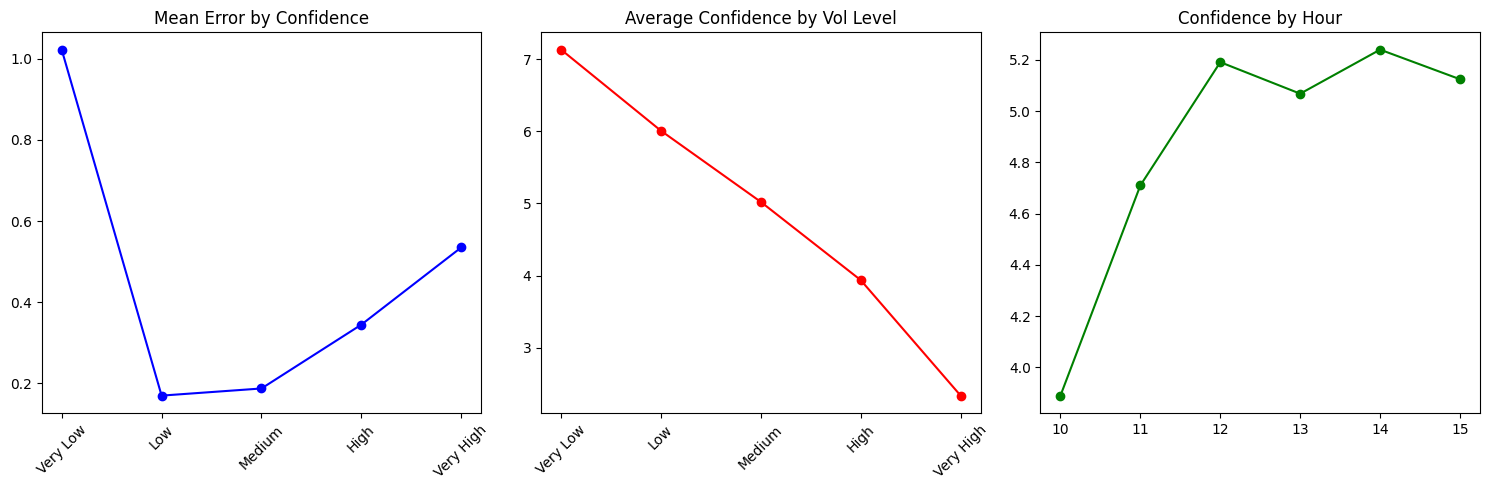

{'quintile_stats':               Y_log_vol_10min_lag_1m                               abs_error  \
                                 mean       std    count <lambda_0>      mean   
 conf_quintile                                                                  
 Very Low                    0.001303  0.001382  1432954        NaN  1.022467   
 Low                         0.000688  0.000887  1434036        NaN  0.170016   
 Medium                      0.000534  0.000854  1432270        NaN  0.187608   
 High                        0.000414  0.000718  1431565        NaN  0.344926   
 Very High                   0.000265  0.000364  1428632        NaN  0.535119   
 
                                   predicted.volatility            
                     std    median                 mean       std  
 conf_quintile                                                     
 Very Low       1.081788  0.702335             1.011368  1.094240  
 Low            0.130669  0.142236             0.070558  0.2

In [24]:
analyze_confidence_vol_relationship_fixed(df)

In [35]:
df.head()

,minute,symbol,ts_event,mid,spread,imbalance,Y_log_ret_10min,Y_log_ret_30min,Y_log_ret_60min,Y_log_ret_10min_lag_1m,...,Y_log_ret_30min_partial,Y_log_ret_60min_partial,predicted.volatility,predicted.returns,predicted.vol_confidence,predicted.ret_confidence,date,hour,minute_in_hour,minutes_from_open
0,09:40,A,2024-06-26 09:40:00-04:00,-0.440334,1.093263,0.565171,-0.002748,-3.901828e-03,-0.004200,-0.005787,...,False,False,NaN,NaN,NaN,NaN,2024-06-26,9,40,10
1,09:45,A,2024-06-26 09:45:00-04:00,-0.442054,0.630831,1.645141,-0.003013,-1.561106e-03,-0.002976,-0.000595,...,False,False,NaN,NaN,NaN,NaN,2024-06-26,9,45,15
2,09:50,A,2024-06-26 09:50:00-04:00,-0.442099,1.100947,-0.045406,-0.001340,3.718924e-05,-0.002569,-0.001340,...,False,False,NaN,NaN,NaN,NaN,2024-06-26,9,50,20
3,09:55,A,2024-06-26 09:55:00-04:00,-0.442235,0.552978,1.575555,0.001601,1.823697e-03,-0.002126,-0.000186,...,False,False,NaN,NaN,NaN,NaN,2024-06-26,9,55,25
4,10:00,A,2024-06-26 10:00:00-04:00,-0.442506,0.553678,1.660946,0.000186,5.612915e-16,-0.002797,0.000075,...,False,False,NaN,NaN,NaN,NaN,2024-06-26,10,0,30


In [25]:
def analyze_prediction_signs(df, conf_col='predicted.vol_confidence', 
                           vol_col='Y_log_vol_10min_lag_1m',
                           pred_col='predicted.volatility'):
    """
    Analyze the sign flip phenomenon in predictions across confidence levels.
    """
    print("\nAnalyzing Sign Patterns in Predictions")
    print("=" * 50)
    
    # Clean data
    valid_data = df.dropna(subset=[conf_col, vol_col, pred_col]).copy()
    
    # Create confidence deciles for finer granularity
    valid_data['conf_decile'] = pd.qcut(valid_data[conf_col], 10, 
                                      labels=[f'D{i+1}' for i in range(10)])
    
    # Add useful derived columns
    valid_data['pred_sign'] = np.sign(valid_data[pred_col])
    valid_data['pred_magnitude'] = np.abs(valid_data[pred_col])
    valid_data['error'] = valid_data[pred_col] - valid_data[vol_col]
    valid_data['rel_error'] = valid_data['error'] / valid_data[vol_col].clip(lower=1e-10)
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour
    
    # 1. Basic sign statistics by confidence decile
    sign_stats = valid_data.groupby('conf_decile').agg({
        'pred_sign': ['mean', 'std', 'size'],  # size gives us count
        'pred_magnitude': ['mean', 'std'],
        pred_col: ['mean', 'std'],
        vol_col: ['mean', 'std'],
        'error': ['mean', 'std']
    }).round(6)
    
    print("\n1. Sign Statistics by Confidence Decile:")
    print(sign_stats)
    
    # 2. Transition analysis
    valid_data = valid_data.sort_values(['symbol', 'date', 'minute'])
    valid_data['sign_change'] = (valid_data.groupby('symbol')['pred_sign']
                                .transform(lambda x: (x != x.shift()).astype(float)))
    
    # Analyze sign changes by confidence
    sign_changes = valid_data.groupby('conf_decile').agg({
        'sign_change': ['mean', 'sum', 'size']
    }).round(4)
    
    print("\n2. Sign Changes by Confidence Decile:")
    print(sign_changes)
    
    # 3. Time of day analysis
    time_pattern = valid_data.groupby(['hour', 'conf_decile']).agg({
        'pred_sign': ['mean', 'std'],
        'pred_magnitude': 'mean',
        'error': 'mean',
        pred_col: 'size'  # Count of predictions
    }).round(6)
    
    print("\n3. Time of Day Patterns:")
    print(time_pattern)
    
    # 4. Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Average prediction by confidence decile
    plt.subplot(1, 3, 1)
    decile_means = valid_data.groupby('conf_decile')[pred_col].mean()
    plt.plot(range(10), decile_means.values, 'bo-')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.title('Mean Prediction by Confidence Decile')
    plt.xticks(range(10), decile_means.index, rotation=45)
    plt.ylabel('Mean Prediction')
    
    # Plot 2: Sign changes by confidence
    plt.subplot(1, 3, 2)
    sign_flip_rate = sign_changes['sign_change']['mean']
    plt.plot(range(10), sign_flip_rate.values, 'ro-')
    plt.title('Sign Change Rate by Confidence')
    plt.xticks(range(10), sign_flip_rate.index, rotation=45)
    plt.ylabel('Sign Change Rate')
    
    # Plot 3: Error magnitude vs confidence
    plt.subplot(1, 3, 3)
    error_magnitude = valid_data.groupby('conf_decile')['error'].apply(lambda x: np.abs(x).mean())
    plt.plot(range(10), error_magnitude.values, 'go-')
    plt.title('Mean Absolute Error by Confidence')
    plt.xticks(range(10), error_magnitude.index, rotation=45)
    plt.ylabel('Mean Absolute Error')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Volatility level analysis
    vol_quintiles = pd.qcut(valid_data[vol_col], 5, labels=['VL', 'L', 'M', 'H', 'VH'])
    valid_data['vol_quintile'] = vol_quintiles
    
    controlled_analysis = valid_data.groupby(['vol_quintile', 'conf_decile']).agg({
        pred_col: ['mean', 'std'],
        'pred_sign': 'mean',
        'error': ['mean', 'std'],
        pred_col: 'size'  # Using pred_col for count since we know it exists
    }).round(6)
    
    print("\n4. Analysis by Volatility Level and Confidence:")
    print(controlled_analysis)
    
    # 6. Analyze sequential behavior
    sequence_analysis = valid_data.groupby('symbol').agg({
        'sign_change': ['mean', 'sum'],
        conf_col: ['mean', 'std'],
        pred_col: ['mean', 'std'],
        'error': ['mean', 'std']
    }).round(6)
    
    print("\n5. Sequential Behavior by Symbol:")
    print(sequence_analysis.describe())
    
    return {
        'sign_stats': sign_stats,
        'sign_changes': sign_changes,
        'time_pattern': time_pattern,
        'vol_confidence_analysis': controlled_analysis,
        'sequence_analysis': sequence_analysis
    }


Analyzing Sign Patterns in Predictions


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/3850958144.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sign_stats = valid_data.groupby('conf_decile').agg({



1. Sign Statistics by Confidence Decile:
            pred_sign                   pred_magnitude            \
                 mean       std    size           mean       std   
conf_decile                                                        
D1           0.971465  0.237183  716175       1.594375  1.274456   
D2           0.857831  0.513933  716779       0.453556  0.264784   
D3           0.535185  0.844736  715833       0.211099  0.146823   
D4          -0.032207  0.999482  718203       0.129618  0.096976   
D5          -0.681510  0.731809  713423       0.149292  0.106667   
D6          -0.963567  0.267469  718847       0.224812  0.107936   
D7          -0.998915  0.046580  716772       0.305384  0.095922   
D8          -0.999994  0.003345  714793       0.383749  0.085556   
D9          -1.000000  0.000000  720344       0.465074  0.082732   
D10         -1.000000  0.000000  708288       0.605821  0.112615   

            predicted.volatility           Y_log_vol_10min_lag_1m        

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/3850958144.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sign_changes = valid_data.groupby('conf_decile').agg({
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/3850958144.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_pattern = valid_data.groupby(['hour', 'conf_decile']).agg({



2. Sign Changes by Confidence Decile:
            sign_change                 
                   mean      sum    size
conf_decile                             
D1               0.0108   7770.0  716175
D2               0.0344  24632.0  716779
D3               0.0686  49081.0  715833
D4               0.0957  68742.0  718203
D5               0.0744  53099.0  713423
D6               0.0256  18369.0  718847
D7               0.0035   2496.0  716772
D8               0.0002    159.0  714793
D9               0.0001     49.0  720344
D10              0.0000     23.0  708288

3. Time of Day Patterns:
                 pred_sign           pred_magnitude     error  \
                      mean       std           mean      mean   
hour conf_decile                                                
10   D1           0.995690  0.092746       1.922711  1.920167   
     D2           0.967314  0.253583       0.624945  0.621089   
     D3           0.866635  0.498944       0.320854  0.308465   
     D4     

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/3850958144.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_means = valid_data.groupby('conf_decile')[pred_col].mean()
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/3850958144.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_magnitude = valid_data.groupby('conf_decile')['error'].apply(lambda x: np.abs(x).mean())


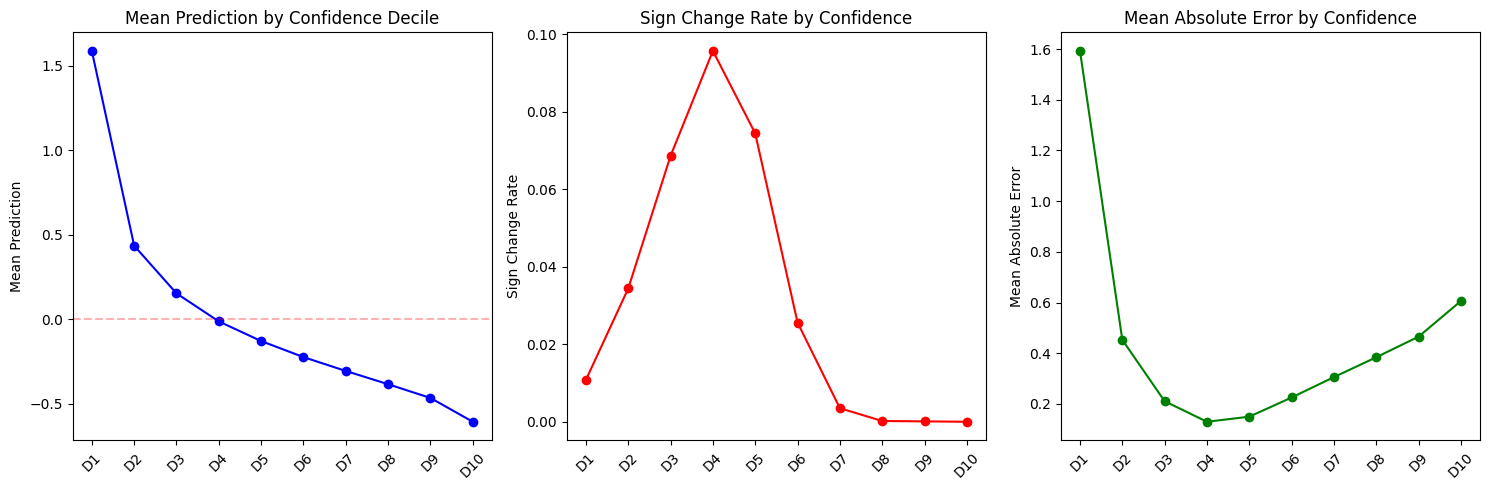

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/3850958144.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  controlled_analysis = valid_data.groupby(['vol_quintile', 'conf_decile']).agg({



4. Analysis by Volatility Level and Confidence:
                         predicted.volatility pred_sign     error          
                                         size      mean      mean       std
vol_quintile conf_decile                                                   
VL           D1                         17961  0.413173  0.373018  0.734681
             D2                         23712  0.067055  0.016871  0.251558
             D3                         34579 -0.474537 -0.102186  0.171631
             D4                         49058 -0.817318 -0.188706  0.137188
             D5                         65252 -0.963342 -0.255857  0.120412
             D6                         92618 -0.997517 -0.318130  0.114878
             D7                        128524 -0.999969 -0.373228  0.106019
             D8                        192456 -1.000000 -0.429852  0.090779
             D9                        304161 -1.000000 -0.500201  0.086378
             D10                       

{'sign_stats':             pred_sign                   pred_magnitude            \
                  mean       std    size           mean       std   
 conf_decile                                                        
 D1           0.971465  0.237183  716175       1.594375  1.274456   
 D2           0.857831  0.513933  716779       0.453556  0.264784   
 D3           0.535185  0.844736  715833       0.211099  0.146823   
 D4          -0.032207  0.999482  718203       0.129618  0.096976   
 D5          -0.681510  0.731809  713423       0.149292  0.106667   
 D6          -0.963567  0.267469  718847       0.224812  0.107936   
 D7          -0.998915  0.046580  716772       0.305384  0.095922   
 D8          -0.999994  0.003345  714793       0.383749  0.085556   
 D9          -1.000000  0.000000  720344       0.465074  0.082732   
 D10         -1.000000  0.000000  708288       0.605821  0.112615   
 
             predicted.volatility           Y_log_vol_10min_lag_1m            \
       

In [26]:
analyze_prediction_signs(df)

In [27]:
df.columns

Index(['minute', 'symbol', 'ts_event', 'mid', 'spread', 'imbalance',
       'Y_log_ret_10min', 'Y_log_ret_30min', 'Y_log_ret_60min',
       'Y_log_ret_10min_lag_1m', 'Y_log_ret_30min_lag_1m',
       'Y_log_ret_60min_lag_1m', 'roll_vol_10m', 'Y_log_vol_10min',
       'Y_log_vol_10min_lag_1m', 'valid_target_10m', 'valid_target_30m',
       'valid_target_60m', 'Y_log_ret_10min_partial',
       'Y_log_ret_30min_partial', 'Y_log_ret_60min_partial',
       'predicted.volatility', 'predicted.returns', 'predicted.vol_confidence',
       'predicted.ret_confidence', 'date', 'hour', 'minute_in_hour',
       'minutes_from_open'],
      dtype='object')

In [28]:
def analyze_joint_predictions(df, 
                            vol_pred='predicted.volatility',
                            ret_pred='predicted.returns',
                            vol_conf='predicted.vol_confidence',
                            ret_conf='predicted.ret_confidence',
                            vol_target='Y_log_vol_10min_lag_1m',
                            ret_target='Y_log_ret_60min_lag_1m'):
    """
    Analyze joint predictions with focus on capital allocation implications.
    """
    print("\nAnalyzing Joint Prediction Patterns")
    print("=" * 50)
    
    # Clean data
    valid_data = df.dropna(subset=[vol_pred, ret_pred, vol_conf, ret_conf, 
                                 vol_target, ret_target]).copy()
    
    # Add derived columns
    valid_data['vol_error'] = valid_data[vol_pred] - valid_data[vol_target]
    valid_data['ret_error'] = valid_data[ret_pred] - valid_data[ret_target]
    valid_data['vol_error_magnitude'] = np.abs(valid_data['vol_error'])
    valid_data['ret_error_magnitude'] = np.abs(valid_data['ret_error'])
    
    # Create quintiles for each metric
    for col in [ret_pred, ret_conf, vol_pred, vol_conf]:
        valid_data[f'{col}_quintile'] = pd.qcut(valid_data[col], 5, 
                                               labels=['VL', 'L', 'M', 'H', 'VH'])
    
    # 1. Joint Confidence Analysis
    joint_conf = valid_data.groupby([f'{ret_conf}_quintile', 
                                   f'{vol_conf}_quintile']).agg({
        'ret_error_magnitude': ['mean', 'std', 'count'],
        'vol_error_magnitude': ['mean', 'std'],
        ret_target: ['mean', 'std'],
        vol_target: ['mean', 'std']
    }).round(6)
    
    print("\n1. Joint Confidence Analysis:")
    print(joint_conf)
    
    # 2. High Confidence Analysis
    # Focus on cases where both models are highly confident
    high_conf = valid_data[
        (valid_data[f'{ret_conf}_quintile'] == 'VH') & 
        (valid_data[f'{vol_conf}_quintile'] == 'VH')
    ]
    
    print("\n2. High Joint Confidence Statistics:")
    print(high_conf[[ret_pred, vol_pred, ret_target, vol_target]].describe())
    
    # 3. Asymmetric Cost Analysis
    def compute_asymmetric_cost(group, ret_weight=2.0):
        """
        Compute asymmetric cost metric:
        - Over-prediction of returns weighted more heavily (actual capital loss)
        - Under-prediction of volatility weighted more heavily (missing opportunity)
        """
        ret_over = (group['ret_error'] > 0).mean()
        vol_under = (group['vol_error'] < 0).mean()
        ret_cost = ret_over * ret_weight
        vol_cost = vol_under
        return pd.Series({
            'ret_over_rate': ret_over,
            'vol_under_rate': vol_under,
            'combined_cost': ret_cost + vol_cost,
            'count': len(group)
        })
    
    cost_analysis = valid_data.groupby([f'{ret_conf}_quintile', 
                                      f'{vol_conf}_quintile']).apply(compute_asymmetric_cost)
    
    print("\n3. Asymmetric Cost Analysis:")
    print(cost_analysis)
    
    # 4. Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Return Prediction Error vs Joint Confidence
    plt.subplot(1, 3, 1)
    conf_levels = ['VL', 'L', 'M', 'H', 'VH']
    errors = [[valid_data[
        (valid_data[f'{ret_conf}_quintile'] == ret_level) & 
        (valid_data[f'{vol_conf}_quintile'] == vol_level)
    ]['ret_error_magnitude'].mean() 
        for ret_level in conf_levels]
        for vol_level in conf_levels]
    
    plt.imshow(errors, cmap='YlOrRd')
    plt.colorbar(label='Mean Return Error')
    plt.title('Joint Confidence vs Return Error')
    plt.xlabel('Return Confidence')
    plt.ylabel('Vol Confidence')
    plt.xticks(range(5), conf_levels)
    plt.yticks(range(5), conf_levels)
    
    # Plot 2: Alpha Scaling Effectiveness
    plt.subplot(1, 3, 2)
    def compute_pnl_ratio(group):
        """Ratio of successful to unsuccessful scaled trades"""
        correct_dir = np.sign(group[ret_pred]) == np.sign(group[ret_target])
        good_scale = np.sign(group[vol_pred]) == np.sign(group[vol_target])
        return (correct_dir & good_scale).sum() / len(group)
    
    pnl_ratios = [[valid_data[
        (valid_data[f'{ret_conf}_quintile'] == ret_level) & 
        (valid_data[f'{vol_conf}_quintile'] == vol_level)
    ].pipe(compute_pnl_ratio)
        for ret_level in conf_levels]
        for vol_level in conf_levels]
    
    plt.imshow(pnl_ratios, cmap='RdYlGn')
    plt.colorbar(label='Success Ratio')
    plt.title('Joint Prediction Success Rate')
    plt.xlabel('Return Confidence')
    plt.ylabel('Vol Confidence')
    plt.xticks(range(5), conf_levels)
    plt.yticks(range(5), conf_levels)
    
    # Plot 3: Asymmetric Cost
    plt.subplot(1, 3, 3)
    costs = cost_analysis['combined_cost'].unstack()
    plt.imshow(costs, cmap='YlOrRd')
    plt.colorbar(label='Combined Cost')
    plt.title('Asymmetric Cost by Confidence')
    plt.xlabel('Return Confidence')
    plt.ylabel('Vol Confidence')
    plt.xticks(range(5), conf_levels)
    plt.yticks(range(5), conf_levels)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Time of Day Pattern
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour
    time_pattern = valid_data.groupby('hour').agg({
        'ret_error_magnitude': ['mean', 'std'],
        'vol_error_magnitude': ['mean', 'std'],
        ret_conf: 'mean',
        vol_conf: 'mean'
    }).round(6)
    
    print("\n4. Time of Day Pattern:")
    print(time_pattern)
    
    return {
        'joint_conf': joint_conf,
        'high_conf': high_conf.describe(),
        'cost_analysis': cost_analysis,
        'time_pattern': time_pattern
    }


Analyzing Joint Prediction Patterns


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1548623352.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  joint_conf = valid_data.groupby([f'{ret_conf}_quintile',



1. Joint Confidence Analysis:
                                                                    ret_error_magnitude  \
                                                                                   mean   
predicted.ret_confidence_quintile predicted.vol_confidence_quintile                       
VL                                VL                                           0.052947   
                                  L                                            0.062230   
                                  M                                            0.085403   
                                  H                                            0.088502   
                                  VH                                           0.074156   
L                                 VL                                           0.024054   
                                  L                                            0.019270   
                                  M                        

/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1548623352.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cost_analysis = valid_data.groupby([f'{ret_conf}_quintile',
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/1548623352.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cost_analysis = valid_data.groupby([f'{ret_conf}_quintile',



3. Asymmetric Cost Analysis:
                                                                     ret_over_rate  \
predicted.ret_confidence_quintile predicted.vol_confidence_quintile                  
VL                                VL                                      0.123807   
                                  L                                       0.874222   
                                  M                                       0.963262   
                                  H                                       0.981385   
                                  VH                                      0.976179   
L                                 VL                                      0.164265   
                                  L                                       0.240549   
                                  M                                       0.473279   
                                  H                                       0.641606   
                        

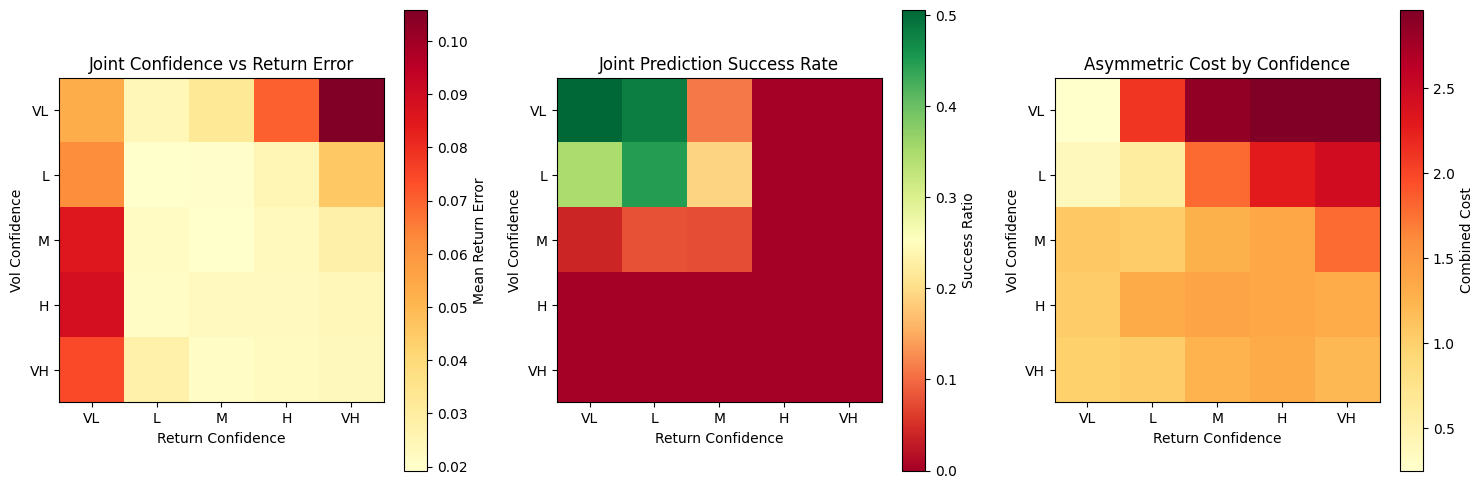


4. Time of Day Pattern:
     ret_error_magnitude           vol_error_magnitude            \
                    mean       std                mean       std   
hour                                                               
10              0.032453  0.032398            0.629511  0.891096   
11              0.024697  0.024183            0.437457  0.607692   
12              0.024947  0.022217            0.417528  0.498046   
13              0.020878  0.021125            0.414434  0.463105   
14              0.027442  0.023313            0.421808  0.464921   
15              0.052053  0.045080            0.408982  0.481416   

     predicted.ret_confidence predicted.vol_confidence  
                         mean                     mean  
hour                                                    
10                   0.382403                 3.890194  
11                   0.523509                 4.710585  
12                   0.576348                 5.191525  
13                  

{'joint_conf':                                                                     ret_error_magnitude  \
                                                                                    mean   
 predicted.ret_confidence_quintile predicted.vol_confidence_quintile                       
 VL                                VL                                           0.052947   
                                   L                                            0.062230   
                                   M                                            0.085403   
                                   H                                            0.088502   
                                   VH                                           0.074156   
 L                                 VL                                           0.024054   
                                   L                                            0.019270   
                                   M                              

In [29]:
analyze_joint_predictions(df)

In [32]:
def analyze_vol_ret_relationship(df, 
                               vol_pred='predicted.volatility',
                               vol_conf='predicted.vol_confidence',
                               ret_target='Y_log_ret_60min_lag_1m'):
    """
    Analyze how volatility predictions and confidence relate to future returns.
    """
    print("\nAnalyzing Volatility-Returns Relationship")
    print("=" * 50)
    
    # Clean data
    valid_data = df.dropna(subset=[vol_pred, vol_conf, ret_target]).copy()
    
    # Create volatility and confidence quintiles
    valid_data['vol_quintile'] = pd.qcut(valid_data[vol_pred], 5, 
                                        labels=['VL', 'L', 'M', 'H', 'VH'])
    valid_data['conf_quintile'] = pd.qcut(valid_data[vol_conf], 5, 
                                         labels=['VL', 'L', 'M', 'H', 'VH'])
    
    # Add absolute returns column
    valid_data['abs_returns'] = np.abs(valid_data[ret_target])
    
    # 1. Basic relationship analysis
    vol_ret_corr = valid_data.groupby('conf_quintile').apply(
        lambda x: x[vol_pred].corr(x['abs_returns'])
    )
    
    print("\n1. Correlation between predicted volatility and absolute returns by confidence:")
    print(vol_ret_corr)
    
    # 2. Return distribution analysis by vol prediction - simplified stats
    ret_stats = valid_data.groupby('vol_quintile')[ret_target].agg([
        'mean', 'std', 'count',
        lambda x: x.skew(),  # Using pandas skew instead
    ]).round(6)
    ret_stats.columns = ['mean', 'std', 'count', 'skew']
    
    print("\n2. Return distribution by predicted volatility quintile:")
    print(ret_stats)
    
    # 3. High confidence analysis
    high_conf = valid_data[valid_data['conf_quintile'] == 'VH']
    high_conf_stats = high_conf.groupby('vol_quintile')[ret_target].agg([
        'mean', 'std', 'count'
    ]).round(6)
    
    print("\n3. Return statistics for high confidence predictions:")
    print(high_conf_stats)
    
    # 4. Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Volatility prediction vs absolute returns
    plt.subplot(1, 3, 1)
    for conf in ['VL', 'VH']:  # Only plot very low and very high confidence
        mask = valid_data['conf_quintile'] == conf
        plt.scatter(valid_data[vol_pred][mask], 
                   valid_data['abs_returns'][mask],
                   alpha=0.1, 
                   label=f'Confidence: {conf}')
    plt.xlabel('Predicted Volatility')
    plt.ylabel('Absolute Returns')
    plt.title('Volatility vs Returns')
    plt.legend()
    
    # Plot 2: Return distribution by vol quintile
    plt.subplot(1, 3, 2)
    vol_groups = valid_data.groupby('vol_quintile')[ret_target]
    plt.boxplot([group[1].values for group in vol_groups],
                labels=vol_groups.groups.keys())
    plt.title('Return Distribution by Vol Quintile')
    plt.ylabel('Returns')
    
    # Plot 3: Confidence impact
    plt.subplot(1, 3, 3)
    accuracy = valid_data.groupby(['vol_quintile', 'conf_quintile']).apply(
        lambda x: np.corrcoef(x[vol_pred], x['abs_returns'])[0,1]
    ).unstack()
    sns.heatmap(accuracy, cmap='RdYlBu', center=0)
    plt.title('Vol-Return Correlation by Confidence')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'vol_ret_corr': vol_ret_corr,
        'ret_stats': ret_stats,
        'high_conf_stats': high_conf_stats
    }


Analyzing Volatility-Returns Relationship


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_ret_corr = valid_data.groupby('conf_quintile').apply(
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vol_ret_corr = valid_data.groupby('conf_quintile').apply(
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:32: FutureWarning: The default of observed=False is deprecated 


1. Correlation between predicted volatility and absolute returns by confidence:
conf_quintile
VL    0.419654
L     0.052786
M     0.025647
H     0.014910
VH    0.058313
dtype: float64

2. Return distribution by predicted volatility quintile:
                  mean       std    count       skew
vol_quintile                                        
VL            0.000222  0.007635  1433184  17.280426
L             0.000252  0.008825  1431323  29.570711
M             0.000240  0.008482  1431463   7.512391
H             0.000190  0.008401  1431820   1.022275
VH           -0.000131  0.013127  1431667  -0.553326


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_conf_stats = high_conf.groupby('vol_quintile')[ret_target].agg([
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_groups = valid_data.groupby('vol_quintile')[ret_target]



3. Return statistics for high confidence predictions:
                  mean       std    count
vol_quintile                             
VL            0.000177  0.007007  1147827
L             0.000197  0.008354   276457
M             0.000067  0.005310     4348
H                  NaN       NaN        0
VH                 NaN       NaN        0


/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group[1].values for group in vol_groups],
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = valid_data.groupby(['vol_quintile', 'conf_quintile']).apply(
/var/folders/st/dv53zgjd1zq71gl_yyg_924w0000gn/T/ipykernel_27204/864555323.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include

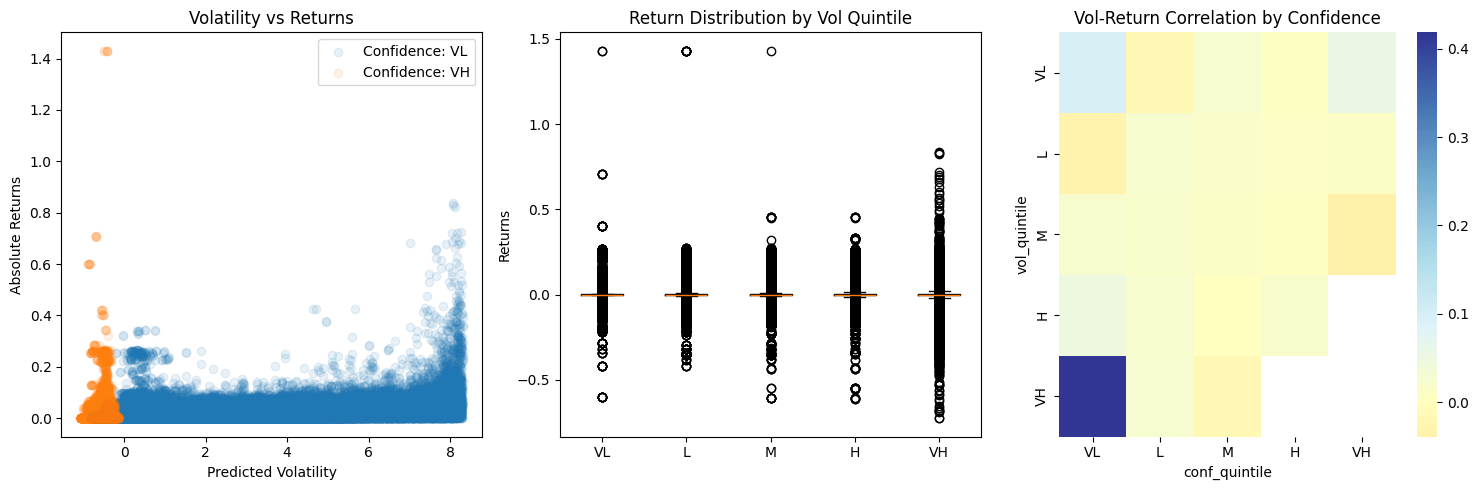

{'vol_ret_corr': conf_quintile
 VL    0.419654
 L     0.052786
 M     0.025647
 H     0.014910
 VH    0.058313
 dtype: float64,
 'ret_stats':                   mean       std    count       skew
 vol_quintile                                        
 VL            0.000222  0.007635  1433184  17.280426
 L             0.000252  0.008825  1431323  29.570711
 M             0.000240  0.008482  1431463   7.512391
 H             0.000190  0.008401  1431820   1.022275
 VH           -0.000131  0.013127  1431667  -0.553326,
 'high_conf_stats':                   mean       std    count
 vol_quintile                             
 VL            0.000177  0.007007  1147827
 L             0.000197  0.008354   276457
 M             0.000067  0.005310     4348
 H                  NaN       NaN        0
 VH                 NaN       NaN        0}

In [33]:
analyze_vol_ret_relationship(df)